#Pythonで学ぶ画像認識　第6章 画像キャプショニング
##第6.3節 CNN-LSTMによる手法〜Show and tellを実装してみよう

###モジュールのインポートとGoogleドライブのマウント

In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import pickle
import random
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from typing import Sequence, Dict, Tuple, Union
from collections import deque

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import models
import torchvision.transforms as T
import torchvision.datasets as dataset

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('drive/MyDrive/python_image_recognition/6_img_captioning/6_3_show_and_tell')

import util

Mounted at /content/drive


### エンコーダの実装

In [2]:
class CNNEncoder(nn.Module):
    '''
    Show and tellのエンコーダ
    dim_embedding: 埋め込み次元
    '''
    def __init__(self, dim_embedding: int):
        super().__init__()

        # ImageNetで事前学習された
        # ResNet152モデルをバックボーンネットワークとする
        resnet = models.resnet152(weights="IMAGENET1K_V2") 

        # 特徴抽出器として使うため全結合層を削除
        modules = list(resnet.children())[:-1]
        self.backbone = nn.Sequential(*modules)

        # デコーダへの出力
        self.linear = nn.Linear(resnet.fc.in_features, dim_embedding)

    '''
    エンコーダの順伝播
    imgs: 入力画像, [バッチサイズ, チャネル数, 高さ, 幅]
    '''
    def forward(self, imgs: torch.Tensor):
        # 特徴抽出 -> [バッチサイズ, 2048]
        # 今回はバックボーンネットワークは学習させない
        with torch.no_grad():
            features = self.backbone(imgs)
            features = features.flatten(1)

        # 全結合
        features = self.linear(features)

        return features

###デコーダの実装

In [3]:
class RNNDecoder(nn.Module):
    '''
    Show and tellのデコーダ
    dim_embedding: 埋め込み次元（単語埋め込み次元）
    dim_hidden   : 隠れ層次元
    vocab_size   : 辞書サイズ
    num_layers   : レイヤー数
    dropout      : ドロップアウト確率
    '''
    def __init__(self, dim_embedding: int, dim_hidden: int, 
                 vocab_size: int, num_layers: int, dropout: int=0.1):
        super().__init__()

        # 単語埋め込み
        self.embed = nn.Embedding(vocab_size, dim_embedding)

        # LSTM
        self.lstm = nn.LSTM(dim_embedding, dim_hidden, 
                            num_layers, batch_first=True)

        # 単語IDへの線形変換
        self.linear = nn.Linear(dim_hidden, vocab_size)

        # ドロップアウト
        self.dropout = nn.Dropout(dropout)

    '''
    デコーダの順伝播
    features: エンコーダ出力特徴, [バッチサイズ, 埋め込み次元]
    captions: 画像キャプション,   [バッチサイズ, 系列長]
    lengths : 系列長のリスト
    '''
    def forward(self, features: torch.Tensor, captions: torch.Tensor,
                lengths: list):

        # 単語埋め込み -> [バッチサイズ, 系列長, 埋め込み次元]
        embeddings = self.embed(captions)

        # 画像埋め込みと単語埋め込みとを連結
        # features.unsqueeze(1) -> [バッチサイズ, 1, 埋め込み次元]
        # 連結後embeddings -> [バッチサイズ, 系列長 + 1, 埋め込み次元]
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        
        # パディングされたTensorを可変長系列に戻してパック
        # packed.data() -> [実際の系列長, 埋め込み次元]
        packed = pack_padded_sequence(embeddings,
                                      lengths, batch_first=True)

        # LSTM
        hiddens, cell = self.lstm(packed)

        # ドロップアウト
        output = self.dropout(hiddens[0])

        # ロジットを取得
        outputs = self.linear(output)

        return outputs

    '''
    サンプリングによる説明文出力（ビームサーチ無し）
    features  : エンコーダ出力特徴, [バッチサイズ, 埋め込み次元]
    states    : LSTM隠れ状態
    max_length: キャプションの最大系列長
    '''
    @torch.no_grad()
    def sample(self, features: torch.Tensor, 
               states=None, max_length=30):

        inputs = features.unsqueeze(1)
        word_idx_list = []

        # 最大系列長まで再帰的に単語をサンプリング予測
        for step_t in range(max_length):
            # LSTM隠れ状態を更新
            hiddens, states = self.lstm(inputs, states)

            # 単語予測
            outputs = self.linear(hiddens.squeeze(1))
            outputs = outputs.softmax(dim=1)
            preds = outputs.argmax(dim=1)
            word_idx_list.append(preds[0].item())
            
            # t+1の入力を作成
            inputs = self.embed(preds)
            inputs = inputs.unsqueeze(1)  

        return word_idx_list

###サンプルからミニバッチを生成するcollate関数

In [4]:
'''
batch     : サンプルした複数の画像とラベルをまとめたもの
word_to_id: 単語->単語ID辞書
'''
def collate_func(batch: Sequence[Tuple[Union[torch.Tensor, str]]],
                 word_to_id: Dict[str, int]):
    imgs, captions = zip(*batch)

    # それぞれのサンプルの5個のキャプションの中から1つを
    # 選択してトークナイズ
    captions = [tokenize_caption(
        random.choice(cap), word_to_id) for cap in captions]

    # キャプションの長さが降順になるように並び替え
    batch = zip(imgs, captions)
    batch = sorted(batch, key=lambda x: len(x[1]), reverse=True)
    imgs, captions = zip(*batch)
    imgs = torch.stack(imgs)

    lengths = [cap.shape[0] for cap in captions]
    targets = torch.full((len(captions), max(lengths)), 
                         word_to_id['<null>'], dtype=torch.int64)
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]
    
    return imgs, targets, lengths

###トークナイザ

In [5]:
'''
トークナイザ - 文章(caption)を単語IDのリスト(tokens_id)に変換
caption   : 画像キャプション
word_to_id: 単語->単語ID辞書
'''
def tokenize_caption(caption: str, word_to_id: Dict[str, int]):
    tokens = caption.lower().split()
    
    tokens_temp = []    
    # 単語についたピリオド、カンマを削除
    for token in tokens:
        if token == '.' or token == ',':
            continue

        token = token.rstrip('.')
        token = token.rstrip(',')
        
        tokens_temp.append(token)
    
    tokens = tokens_temp        
        
    # 文章(caption)を単語IDのリスト(tokens_id)に変換
    tokens_ext = ['<start>'] + tokens + ['<end>']
    tokens_id = []
    for k in tokens_ext:
        if k in word_to_id:
            tokens_id.append(word_to_id[k])
        else:
            tokens_id.append(word_to_id['<unk>'])
    
    return torch.Tensor(tokens_id)

###学習におけるハイパーパラメータやオプションの設定

In [6]:
class ConfigTrain(object):
    '''
    ハイパーパラメータ、グローバル変数の設定
    '''  
    def __init__(self):

        # ハイパーパラメータ
        self.dim_embedding = 300 # 埋め込み層の次元
        self.dim_hidden = 128     # LSTM隠れ層の次元
        self.num_layers = 2        # LSTM階層の数
        self.lr = 0.001             # 学習率
        self.dropout = 0.3         # dropout確率
        self.batch_size = 30       # ミニバッチ数
        self.num_epochs = 100    # エポック数
        self.lr_drop = [20]         # 学習率を減衰させるエポック
        
        # パスの設定
        self.img_directory = 'val2014'
        self.anno_file = 'drive/MyDrive/python_image_recognition/data/coco2014/captions_val2014.json'
        self.word_to_id_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/vocab/word_to_id.pkl'
        self.save_directory = 'drive/MyDrive/python_image_recognition/6_img_captioning/model'

        # 検証に使う学習セット内のデータの割合
        self.val_ratio = 0.3

        # データローダーに使うCPUプロセスの数
        self.num_workers = 4

        # 学習に使うデバイス
        self.device = 'cuda'

        # 移動平均で計算する損失の値の数
        self.moving_avg = 100

### 学習を行う関数

In [7]:
def train():
    config = ConfigTrain()

    # 辞書（単語→単語ID）の読み込み
    with open(config.word_to_id_file, 'rb') as f:
        word_to_id = pickle.load(f)

    # 辞書サイズを保存
    vocab_size = len(word_to_id)
        
    # モデル出力用のディレクトリを作成
    os.makedirs(config.save_directory, exist_ok=True)

    # 画像のtransformsを定義
    transforms = T.Compose([
        T.Resize((224, 224)),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])

    # COCOデータロードの定義
    train_dataset = dataset.CocoCaptions(root=config.img_directory, 
                                         annFile=config.anno_file, 
                                         transform=transforms)
    
    # Subset samplerの生成
    val_set, train_set = util.generate_subset(
        train_dataset, config.val_ratio)

    # 学習時にランダムにサンプルするためのサンプラー
    train_sampler = SubsetRandomSampler(train_set)

    # DataLoaderを生成
    collate_func_lambda = lambda x: collate_func(x, word_to_id)
    train_loader = torch.utils.data.DataLoader(
                        train_dataset, 
                        batch_size=config.batch_size, 
                        num_workers=config.num_workers, 
                        sampler=train_sampler,
                        collate_fn=collate_func_lambda)
    val_loader = torch.utils.data.DataLoader(
                        train_dataset, 
                        batch_size=config.batch_size, 
                        num_workers=config.num_workers, 
                        sampler=val_set,
                        collate_fn=collate_func_lambda)

    # モデルの定義
    encoder = CNNEncoder(config.dim_embedding)
    decoder = RNNDecoder(
        config.dim_embedding, config.dim_hidden, vocab_size, 
        config.num_layers, config.dropout)
    encoder.to(config.device)
    decoder.to(config.device)
    
    # 損失関数の定義
    loss_func = lambda x, y: F.cross_entropy(
        x, y, ignore_index=word_to_id.get('<null>', None))
    
    # 最適化手法の定義
    params = list(decoder.parameters()) \
             + list(encoder.linear.parameters())
    optimizer = torch.optim.AdamW(params, lr=config.lr)

    # 学習率スケジューラの定義
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
                    optimizer, milestones=config.lr_drop, gamma=0.1)
    
    # 学習経過の書き込み
    now = datetime.datetime.now()
    train_loss_file = '{}/6-3_train_loss_{}.csv'\
        .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))
    val_loss_file = '{}/6-3_val_loss_{}.csv'\
        .format(config.save_directory, now.strftime('%Y%m%d_%H%M%S'))

    # 学習
    val_loss_best = float('inf')
    for epoch in range(config.num_epochs):
        with tqdm(train_loader) as pbar:
            pbar.set_description(f'[エポック {epoch + 1}]')

            # 学習モードに設定
            encoder.train()
            decoder.train()

            train_losses = deque()
            for imgs, captions, lengths in pbar:
                # ミニバッチを設定
                imgs = imgs.to(config.device)
                captions = captions.to(config.device)

                optimizer.zero_grad()

                # エンコーダ-デコーダモデル
                features = encoder(imgs)
                outputs = decoder(features, captions, lengths)

                # ロスの計算
                targets = pack_padded_sequence(captions, 
                                               lengths, 
                                               batch_first=True)[0]
                loss = loss_func(outputs, targets)

                # 誤差逆伝播
                loss.backward()
                
                optimizer.step()

                # 学習時の損失をログに書き込み
                train_losses.append(loss.item())
                if len(train_losses) > config.moving_avg:
                    train_losses.popleft()
                pbar.set_postfix({
                    'loss': torch.Tensor(train_losses).mean().item()})
                with open(train_loss_file, 'a') as f:
                    print(f'{epoch}, {loss.item()}', file=f)

        # 検証
        with tqdm(val_loader) as pbar:
            pbar.set_description(f'[検証]')

            # 評価モード
            encoder.eval()
            decoder.eval()

            val_losses = []
            for imgs, captions, lengths in pbar:

                # ミニバッチを設定
                imgs = imgs.to(config.device)
                captions = captions.to(config.device)

                # エンコーダ-デコーダモデル
                features = encoder(imgs)
                outputs = decoder(features, captions, lengths)

                # ロスの計算
                targets = pack_padded_sequence(captions, 
                                               lengths, 
                                               batch_first=True)[0]
                loss = loss_func(outputs, targets)
                val_losses.append(loss.item())

                # Validation Lossをログに書き込み
                with open(val_loss_file, 'a') as f:
                    print(f'{epoch}, {loss.item()}', file=f)

        # Loss 表示
        val_loss = np.mean(val_losses)
        print(f'Validation loss: {val_loss}')

        # より良い検証結果が得られた場合、モデルを保存
        if val_loss < val_loss_best:
            val_loss_best = val_loss

            # エンコーダモデルを保存
            torch.save(
                encoder.state_dict(),
                f'{config.save_directory}/6-3_encoder_best.pth')

            # デコーダモデルを保存
            torch.save(
                decoder.state_dict(),
                f'{config.save_directory}/6-3_decoder_best.pth')

###学習データの解凍

In [8]:
!unzip drive/MyDrive/python_image_recognition/data/coco2014/val2014.zip

ストリーミング出力は最後の 5000 行に切り捨てられました。
 extracting: val2014/COCO_val2014_000000535608.jpg  
 extracting: val2014/COCO_val2014_000000279145.jpg  
 extracting: val2014/COCO_val2014_000000243495.jpg  
 extracting: val2014/COCO_val2014_000000225791.jpg  
 extracting: val2014/COCO_val2014_000000428067.jpg  
 extracting: val2014/COCO_val2014_000000059383.jpg  
 extracting: val2014/COCO_val2014_000000558498.jpg  
 extracting: val2014/COCO_val2014_000000376123.jpg  
 extracting: val2014/COCO_val2014_000000191304.jpg  
 extracting: val2014/COCO_val2014_000000171062.jpg  
 extracting: val2014/COCO_val2014_000000014549.jpg  
 extracting: val2014/COCO_val2014_000000121152.jpg  
 extracting: val2014/COCO_val2014_000000276596.jpg  
 extracting: val2014/COCO_val2014_000000029431.jpg  
 extracting: val2014/COCO_val2014_000000036349.jpg  
 extracting: val2014/COCO_val2014_000000502055.jpg  
 extracting: val2014/COCO_val2014_000000438848.jpg  
 extracting: val2014/COCO_val2014_000000364973.jpg  
 extracting: v

###学習の実行

In [9]:
train()

loading annotations into memory...
Done (t=1.67s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.01it/s]


Validation loss: 3.8560754242788984


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.01it/s]


Validation loss: 3.5781862911919653


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.06it/s]


Validation loss: 3.3446641361772134


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.10it/s]


Validation loss: 3.1474061711081145


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.00it/s]


Validation loss: 2.998506584778208


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.06it/s]


Validation loss: 2.921554054532732


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.98it/s]


Validation loss: 2.8500854499234354


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.06it/s]


Validation loss: 2.814082135120636


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.01it/s]


Validation loss: 2.755212371866104


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.94it/s]


Validation loss: 2.731336573661842


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.95it/s]


Validation loss: 2.716843555713522


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.92it/s]


Validation loss: 2.6923395571450293


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.94it/s]


Validation loss: 2.66023588180542


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.81it/s]


Validation loss: 2.6525573210763227


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.98it/s]


Validation loss: 2.6242410954583453


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.93it/s]


Validation loss: 2.6043901390630038


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.77it/s]


Validation loss: 2.609935639820663


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.98it/s]


Validation loss: 2.5907699427581186


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.80it/s]


Validation loss: 2.5870700405149036


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.99it/s]


Validation loss: 2.580511773454732


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.01it/s]


Validation loss: 2.571745738313703


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.87it/s]


Validation loss: 2.5621871930625053


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.90it/s]


Validation loss: 2.5645594332605746


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.92it/s]


Validation loss: 2.5575111646370345


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.85it/s]


Validation loss: 2.5505258840293132


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.81it/s]


Validation loss: 2.5519758216265975


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.87it/s]


Validation loss: 2.5423892260772254


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.77it/s]


Validation loss: 2.547348087057104


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.92it/s]


Validation loss: 2.5414634299982946


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.83it/s]


Validation loss: 2.53066425194294


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.05it/s]


Validation loss: 2.5206047543163956


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.06it/s]


Validation loss: 2.5084112119204893


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.87it/s]


Validation loss: 2.5129621075879176


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.02it/s]


Validation loss: 2.5177821549288746


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.88it/s]


Validation loss: 2.5131383955185047


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.98it/s]


Validation loss: 2.5079629735406397


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.87it/s]


Validation loss: 2.519796693266319


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.95it/s]


Validation loss: 2.5155446288620897


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.96it/s]


Validation loss: 2.496078938979821


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.86it/s]


Validation loss: 2.5072313958200914


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.76it/s]


Validation loss: 2.48448557160758


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.78it/s]


Validation loss: 2.491837920813725


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.97it/s]


Validation loss: 2.486216674297314


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.70it/s]


Validation loss: 2.507762967952954


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.82it/s]


Validation loss: 2.492953994591248


[検証]: 100%|██████████| 406/406 [00:32<00:00, 12.69it/s]


Validation loss: 2.4956598895523934


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.80it/s]


Validation loss: 2.4889295286145705


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.82it/s]


Validation loss: 2.4921846072662053


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.84it/s]


Validation loss: 2.487622272792121


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.84it/s]


Validation loss: 2.490157479135861


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.78it/s]


Validation loss: 2.4724976778617633


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.80it/s]


Validation loss: 2.4872678530040044


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.79it/s]


Validation loss: 2.4790920782559023


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.80it/s]


Validation loss: 2.4793570634766753


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.79it/s]


Validation loss: 2.4846703642107584


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.84it/s]


Validation loss: 2.4786213783207787


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.86it/s]


Validation loss: 2.4700182969934246


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.84it/s]


Validation loss: 2.4851510821304883


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.87it/s]


Validation loss: 2.481167421258729


[検証]: 100%|██████████| 406/406 [00:32<00:00, 12.60it/s]


Validation loss: 2.4802669618517306


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.96it/s]


Validation loss: 2.473997265247289


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.80it/s]


Validation loss: 2.481241621113763


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.80it/s]


Validation loss: 2.4762777744842865


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.87it/s]


Validation loss: 2.4686065674415363


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.98it/s]


Validation loss: 2.476031311333473


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.02it/s]


Validation loss: 2.4757565151294463


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.80it/s]


Validation loss: 2.4666111777568687


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.83it/s]


Validation loss: 2.4926580769087883


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.77it/s]


Validation loss: 2.488630351174641


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.73it/s]


Validation loss: 2.468407876092225


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.81it/s]


Validation loss: 2.472933578961001


[検証]: 100%|██████████| 406/406 [00:32<00:00, 12.60it/s]


Validation loss: 2.4775121446900767


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.78it/s]


Validation loss: 2.4846853279127865


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.74it/s]


Validation loss: 2.4711271357066527


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.79it/s]


Validation loss: 2.49105506371982


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.73it/s]


Validation loss: 2.46917814339323


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.83it/s]


Validation loss: 2.4719379708684723


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.71it/s]


Validation loss: 2.4839278386144215


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.79it/s]


Validation loss: 2.461824854312859


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.02it/s]


Validation loss: 2.481516952291498


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.04it/s]


Validation loss: 2.451110513633108


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.06it/s]


Validation loss: 2.4724994856735756


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.10it/s]


Validation loss: 2.474596434919705


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.15it/s]


Validation loss: 2.4667466021523685


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.09it/s]


Validation loss: 2.477159263758824


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.16it/s]


Validation loss: 2.48646243334991


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.91it/s]


Validation loss: 2.481640288982485


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.85it/s]


Validation loss: 2.481553554534912


[検証]: 100%|██████████| 406/406 [00:30<00:00, 13.11it/s]


Validation loss: 2.487028640772909


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.99it/s]


Validation loss: 2.4596854175252867


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.09it/s]


Validation loss: 2.4466977148807696


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.91it/s]


Validation loss: 2.470148551640252


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.93it/s]


Validation loss: 2.467984104978627


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.04it/s]


Validation loss: 2.4672498717683875


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.96it/s]


Validation loss: 2.477656126022339


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.88it/s]


Validation loss: 2.4811313281505565


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.85it/s]


Validation loss: 2.4738433267095408


[検証]: 100%|██████████| 406/406 [00:31<00:00, 13.07it/s]


Validation loss: 2.471231885437895


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.82it/s]


Validation loss: 2.4756299638983066


[検証]: 100%|██████████| 406/406 [00:31<00:00, 12.77it/s]


Validation loss: 2.4759621620178223


###デモにおけるハイパーパラメータやオプションの設定

In [7]:
class ConfigDemo(object):
    '''
    ハイパーパラメータ、グローバル変数の設定
    '''  
    def __init__(self):

        # ハイパーパラメータ
        self.dim_embedding = 300   # 埋め込み層の次元
        self.dim_hidden = 128      # LSTM隠れ層の次元
        self.num_layers = 2        # LSTM階層の数
        
        # パスの設定
        # 画像キャプショニング推論
        self.id_to_word_file = 'drive/MyDrive/python_image_recognition/6_img_captioning/vocab/id_to_word.pkl'
        self.img_dirirectory = 'drive/MyDrive/python_image_recognition/data/image_captioning/'    
        self.save_directory = 'drive/MyDrive/python_image_recognition/6_img_captioning/model'

        # 学習に使うデバイス
        self.device = 'cuda'

###デモを行う関数

In [8]:
def demo():
    config = ConfigDemo()

    # 辞書（単語ID→単語）の読み込み
    with open(config.id_to_word_file, 'rb') as f:
        id_to_word = pickle.load(f)

    # 辞書サイズを保存
    vocab_size = len(id_to_word)
    
    # 画像のtransformsを定義
    transforms = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        # ImageNetデータセットの平均と標準偏差
        T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) 
    ])
    
    # エンコーダモデルの定義
    encoder = CNNEncoder(config.dim_embedding)
    encoder.to(config.device)
    encoder.eval()

    # デコーダモデルの定義
    decoder = RNNDecoder(config.dim_embedding, config.dim_hidden, 
                         vocab_size, config.num_layers)
    decoder.to(config.device)
    decoder.eval()

    # モデルの学習済み重みパラメータをロード
    encoder.load_state_dict(
        torch.load(f'{config.save_directory}/6-3_encoder_best.pth'))
    decoder.load_state_dict(
        torch.load(f'{config.save_directory}/6-3_decoder_best.pth'))

    # ディレクトリ内の画像を対象としてキャプショニング実行
    for img_file in sorted(
        glob.glob(os.path.join(config.img_dirirectory, '*.jpg'))):

        # 画像読み込み
        img = Image.open(img_file)
        img = transforms(img)
        img = img.unsqueeze(0)
        img = img.to(config.device)

        # エンコーダ・デコーダモデルによる予測
        feature = encoder(img)
        sampled_ids = decoder.sample(feature)

        # 入力画像を表示
        img_plt = Image.open(img_file)
        img_plt = img_plt.resize([224, 224], Image.LANCZOS)
        plt.imshow(img_plt)
        plt.axis('off')
        plt.show()
        print(f'入力画像: {os.path.basename(img_file)}')

        # 画像キャプショニングの実行
        sampled_caption = []
        for word_id in sampled_ids:
            word = id_to_word[word_id]
            sampled_caption.append(word)
            if word == '<end>':
                break
        
        sentence = ' '.join(sampled_caption)
        print(f'出力キャプション: {sentence}')

        # 推定結果を書き込み
        gen_sentence_out = img_file[:-4] + "_show_and_tell.txt"
        with open(gen_sentence_out, 'w') as f:
            print(sentence, file=f)

###デモの実行

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

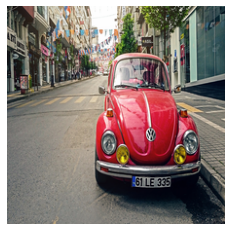

入力画像: automotive-1846910_1920.jpg
出力キャプション: <start> a car parked in a parking lot next to a car <end>


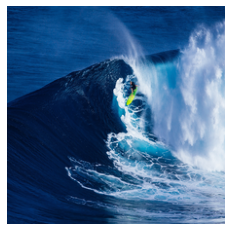

入力画像: beach-1837030_1920.jpg
出力キャプション: <start> a man riding a surfboard on a wave in the ocean <end>


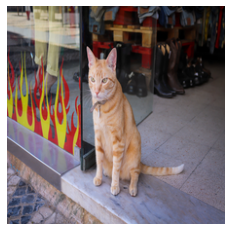

入力画像: cat-4467818_1920.jpg
出力キャプション: <start> a cat sitting on a bench in a room <end>


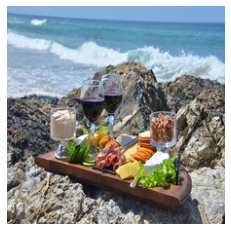

入力画像: cheese-platter-1867456_1920.jpg
出力キャプション: <start> a group of people sitting on a bench in a park <end>


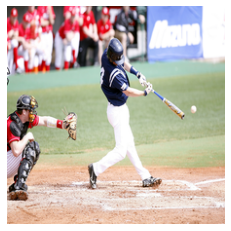

入力画像: hit-1407826_1920.jpg
出力キャプション: <start> a baseball player is swinging a bat at a ball <end>


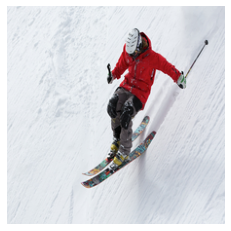

入力画像: man-498473_1920.jpg
出力キャプション: <start> a person on skis in the snow with a snowboard <end>


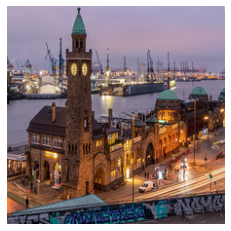

入力画像: port-5788261_1920.jpg
出力キャプション: <start> a large building with a clock on it <end>


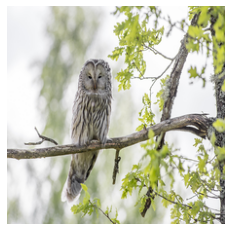

入力画像: ural-owl-4808774_1920.jpg
出力キャプション: <start> a bird is perched on a branch in a tree <end>


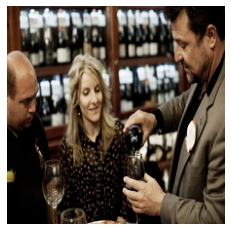

入力画像: wine-bar-2139973_1920.jpg
出力キャプション: <start> a man and a woman are sitting at a table with a wine glass <end>


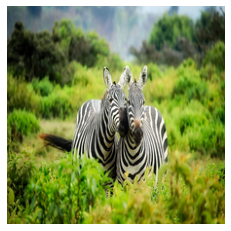

入力画像: zebras-1883654_1920.jpg
出力キャプション: <start> a zebra standing in a field with a tree <end>


In [9]:
demo()